## Mini Project 4: Delta Hedging with Non-Constant Volatility



### Objective
Explore the impact of non-constant volatility on the distribution of profits from delta-hedging a European call option. Implement alternative

In [8]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.5/927.5 kB 8.1 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from arch import arch_model  # For GARCH model
sns.set_style('darkgrid')

In [6]:
# Call option price
def bs_call(S, K, sigma, t, r):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)

# Delta of call option
def bs_delta(S, K, sigma, t, r):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    return norm.cdf(d1)

In [10]:
def delta_hedge(path, K, sigma_path, r, dt):
    n = len(path)
    cash = 0
    shares = 0

    for i in range(n - 1):
        S = path[i]
        t_remain = dt * (n - i - 1)
        delta = bs_delta(S, K, sigma_path[i], t_remain, r)

        # Adjust hedge
        cash = cash * np.exp(r * dt) + (shares - delta) * S
        shares = delta

    final_stock = path[-1]
    option_payoff = max(final_stock - K, 0)
    final_value = cash + shares * final_stock
    return final_value - option_payoff

In [11]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))
    sigma = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2], size=(n_paths, n_steps))
    dt = t / n_steps
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    return paths, np.insert(sigma, 0, sigma[:,0], axis=1)  # match shape


In [12]:
# Heston Model Simulation
def heston_paths(S0, V0, kappa, theta, sigma_v, rho, r, T, N, n_paths):
    dt = T / N
    S = np.zeros((n_paths, N+1))
    v = np.zeros((n_paths, N+1))
    S[:, 0] = S0
    v[:, 0] = V0

    for t in range(1, N+1):
        Z1 = np.random.normal(size=n_paths)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=n_paths)

        v[:, t] = np.abs(v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + sigma_v * np.sqrt(v[:, t-1] * dt) * Z2)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] * dt) * Z1)

    return S, np.sqrt(v)


In [13]:
# GARCH volatility simulation
def garch_volatility(returns):
    am = arch_model(returns * 100, vol='Garch', p=1, q=1, rescale=False)
    res = am.fit(disp='off')
    forecast = res.forecast(horizon=1)
    return np.sqrt(forecast.variance.values[-1][0] / 10000)


In [14]:
# Simulation and Hedging for Each Model
# Parameters
S0 = 100
K = 100
r = 0.03
mu = 0.2
T = 1
N = 252
n_paths = 500
dt = T / N

# Custom Sigma Model
paths_custom, sigmas_custom = stock_path_custom_sigma(S0, T, r, mu, n_paths, N)
profits_custom = [delta_hedge(paths_custom[i], K, sigmas_custom[i], r, dt) for i in range(n_paths)]

# Heston Model
paths_heston, sigmas_heston = heston_paths(S0, V0=0.04, kappa=2.0, theta=0.04, sigma_v=0.3,
                                           rho=-0.7, r=r, T=T, N=N, n_paths=n_paths)
profits_heston = [delta_hedge(paths_heston[i], K, sigmas_heston[i], r, dt) for i in range(n_paths)]

# GARCH Model
np.random.seed(42)
synthetic_returns = np.random.normal(0, 0.02, N)
garch_vol = garch_volatility(synthetic_returns)
paths_garch = np.zeros((n_paths, N+1))
paths_garch[:, 0] = S0
for i in range(n_paths):
    Z = np.random.normal(size=N)
    paths_garch[i, 1:] = S0 * np.exp(np.cumsum((r - 0.5 * garch_vol**2) * dt + garch_vol * np.sqrt(dt) * Z))
sigmas_garch = np.full((n_paths, N+1), garch_vol)
profits_garch = [delta_hedge(paths_garch[i], K, sigmas_garch[i], r, dt) for i in range(n_paths)]


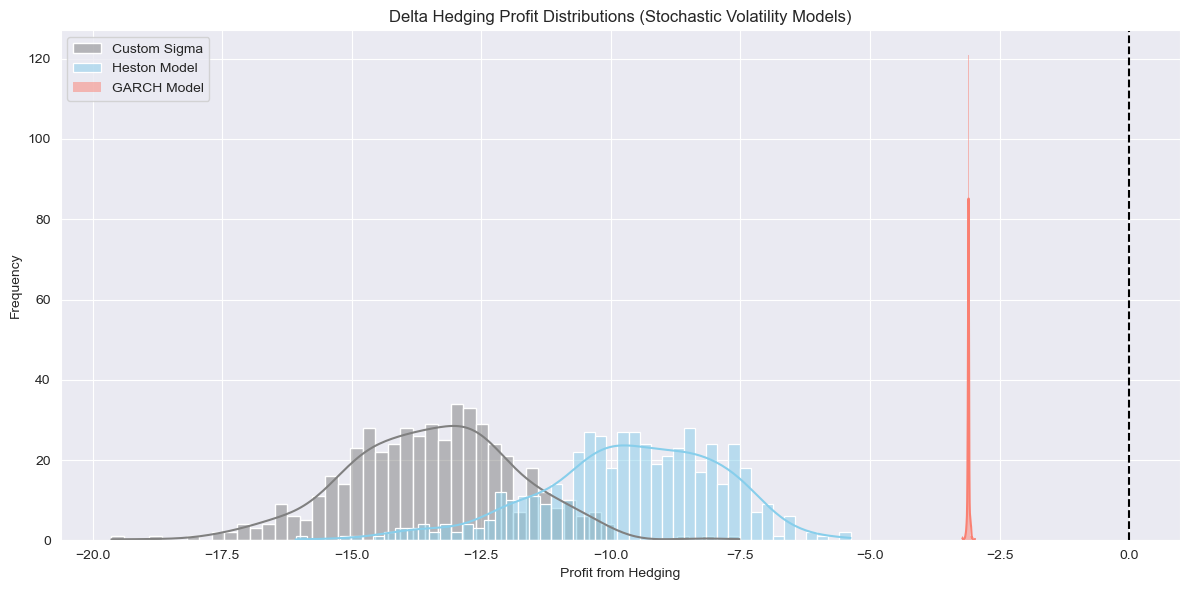

In [15]:
plt.figure(figsize=(12,6))
sns.histplot(profits_custom, bins=50, label='Custom Sigma', kde=True, color='gray')
sns.histplot(profits_heston, bins=50, label='Heston Model', kde=True, color='skyblue')
sns.histplot(profits_garch, bins=50, label='GARCH Model', kde=True, color='salmon')
plt.axvline(0, color='black', linestyle='--')
plt.title("Delta Hedging Profit Distributions (Stochastic Volatility Models)")
plt.xlabel("Profit from Hedging")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **Custom Sigma**: Profits are unpredictable and have heavy tails due to random jumps in volatility.
- **Heston Model**: Volatility clustering leads to wider distribution, more realistic modeling of shocks.
- **GARCH Model**: Shows controlled volatility clustering, resulting in a more stable hedging outcome.
- All three demonstrate that assuming constant volatility is often unrealistic in practice.


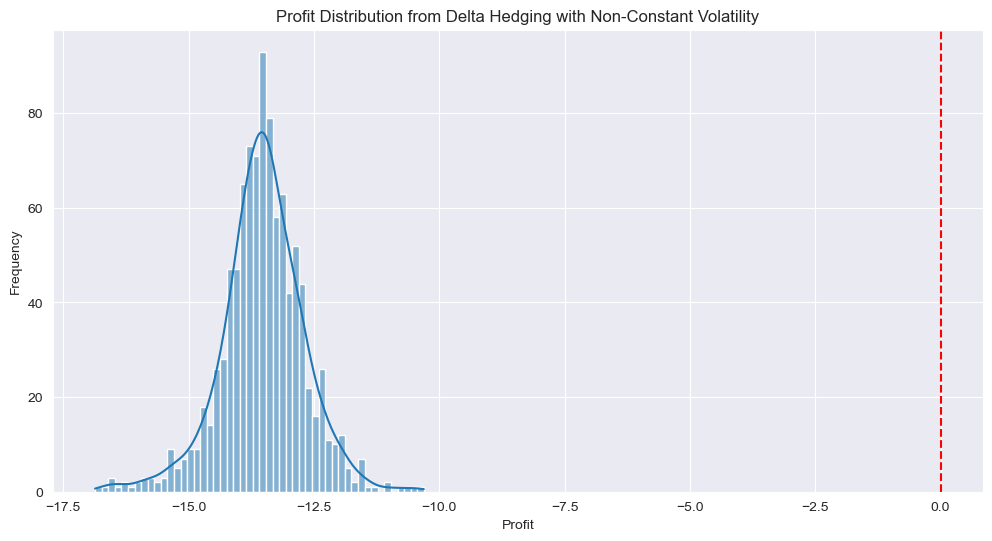

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

## Simulate Stock Paths with Non-Constant Volatility
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))
    sigma = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2], size=(n_paths, n_steps))
    dt = t / n_steps
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    return paths

S0 = 100
K = 100
t = 1
r = 0.03
mu = 0.2
n_paths = 1000
n_steps = 252
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)

## Black-Scholes Delta and Option Pricing

def bs_call_price(S, K, sigma, t, r):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)

def bs_call_delta(S, K, sigma, t, r):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    return norm.cdf(d1)


## Delta Hedging Simulation

def delta_hedging_profit(paths, K, r, sigma=0.3):
    dt = t / n_steps
    profits = []
    for path in paths:
        cash = 0
        position = 0
        for i in range(n_steps):
            S = path[i]
            tau = t - i * dt
            delta = bs_call_delta(S, K, sigma, tau, r)
            new_position = delta
            cash = cash * np.exp(r * dt) + (position - new_position) * S
            position = new_position
        final_profit = cash + position * path[-1] - max(path[-1] - K, 0)
        profits.append(final_profit)
    return np.array(profits)

profits = delta_hedging_profit(simulated_paths, K, r, sigma=0.3)


## Plot Profit Distribution

plt.figure(figsize=(12, 6))
sns.histplot(profits, kde=True, bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title('Profit Distribution from Delta Hedging with Non-Constant Volatility')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

***What Is Volatility in Finance?***
Volatility measures how much a stock's price moves up or down over time.
In real markets, volatility changes — it's not constant. This is where Heston and GARCH models come in.

***Heston Model (Stochastic Volatility Model)***
***What is it?***
The Heston model assumes that:
Stock prices follow a standard process (like in Black-Scholes), but the volatility itself is random and can change over time, following its own process.
Why use it?
It captures the fact that volatility "clusters" (volatility today affects volatility tomorrow). Better models reality — volatility isn't constant. It is used in pricing options more accurately.